2024-07-14 20:04:49.057529: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 20:05:15.315759: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 20:05:28.476482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.


2024-07-14 20:05:54.263530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 20:06:03.028791: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 20:06:03.032542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50


2024-07-14 20:06:22.251550: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1720987603.760273   10573 service.cc:145] XLA service 0x7f9cba64eae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720987603.760313   10573 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-14 20:06:44.184237: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720987604.949476   10573 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 [==============================] - ETA: 0s - loss: 0.8377 - accuracy: 0.6151
Epoch 1: val_loss improved from inf to 0.47823, saving model to classification_model.keras
40/40 [==============================] - 69s 519ms/step - loss: 0.8377 - accuracy: 0.6151 - val_loss: 0.4782 - val_accuracy: 0.8208 - lr: 1.0000e-04
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.7810
Epoch 2: val_loss improved from 0.47823 to 0.40224, saving model to classification_model.keras
40/40 [==============================] - 19s 473ms/step - loss: 0.5073 - accuracy: 0.7810 - val_loss: 0.4022 - val_accuracy: 0.8239 - lr: 1.0000e-04
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.7960
Epoch 3: val_loss improved from 0.40224 to 0.35705, saving model to classification_model.keras
40/40 [==============================] - 17s 425ms/step - loss: 0.4817 - accuracy: 0.7960 - val_loss: 0.3571 - val_accuracy: 0.8365 - lr: 1.0000e-04
E

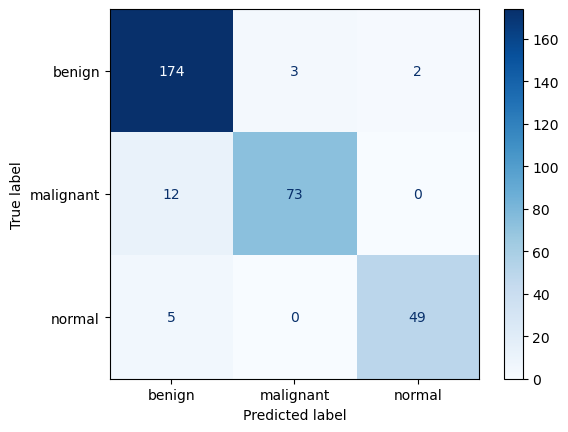

1/1 [==============================] - 1s 596ms/step


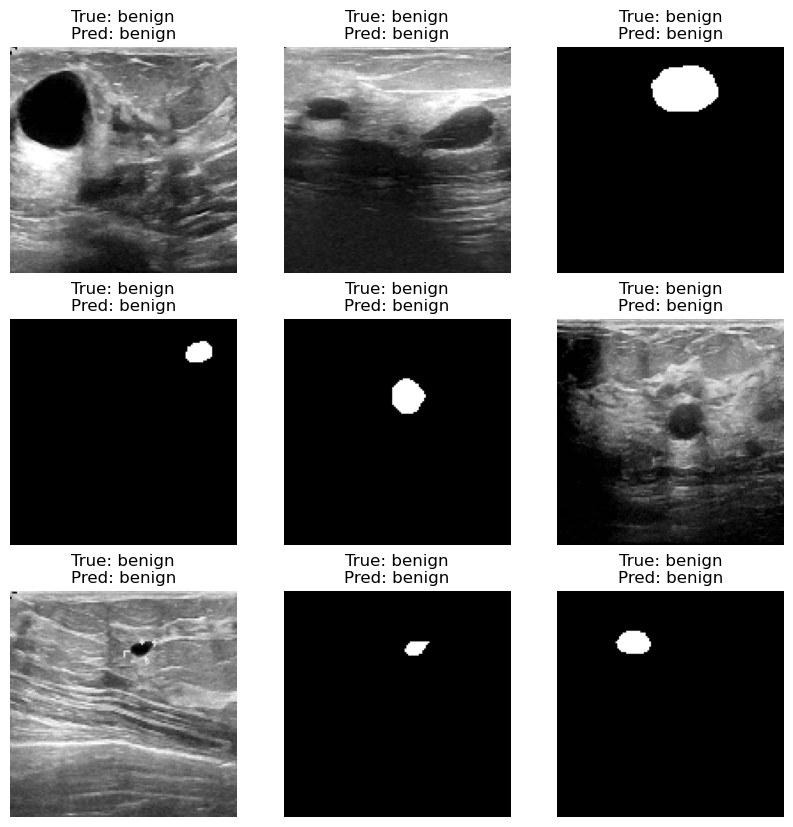

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the dataset path and labels
base_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
new_base_dir = 'breast_ultrasound_images/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
classes = ['benign', 'malignant', 'normal']

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 8.7455 - accuracy: 0.7048
Epoch 1: val_loss improved from inf to 9.48621, saving model to classification_model_resnet50.keras
40/40 [==============================] - 59s 452ms/step - loss: 8.7455 - accuracy: 0.7048 - val_loss: 9.4862 - val_accuracy: 0.2358 - lr: 1.0000e-04
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 8.1703 - accuracy: 0.7690
Epoch 2: val_loss improved from 9.48621 to 9.22513, saving model to classification_model_resnet50.keras
40/40 [==============================] - 13s 321ms/step - loss: 8.1703 - accuracy: 0.7690 - val_loss: 9.2251 - val_accuracy: 0.1824 - lr: 1.0000e-04
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 7.6038 - accuracy: 0.8143
Epoch 3: val_loss improved from 9.22513 to 8.85151, saving model to 

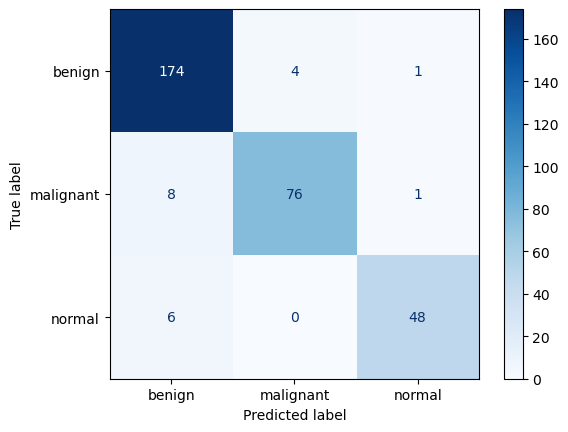

1/1 [==============================] - 4s 4s/step


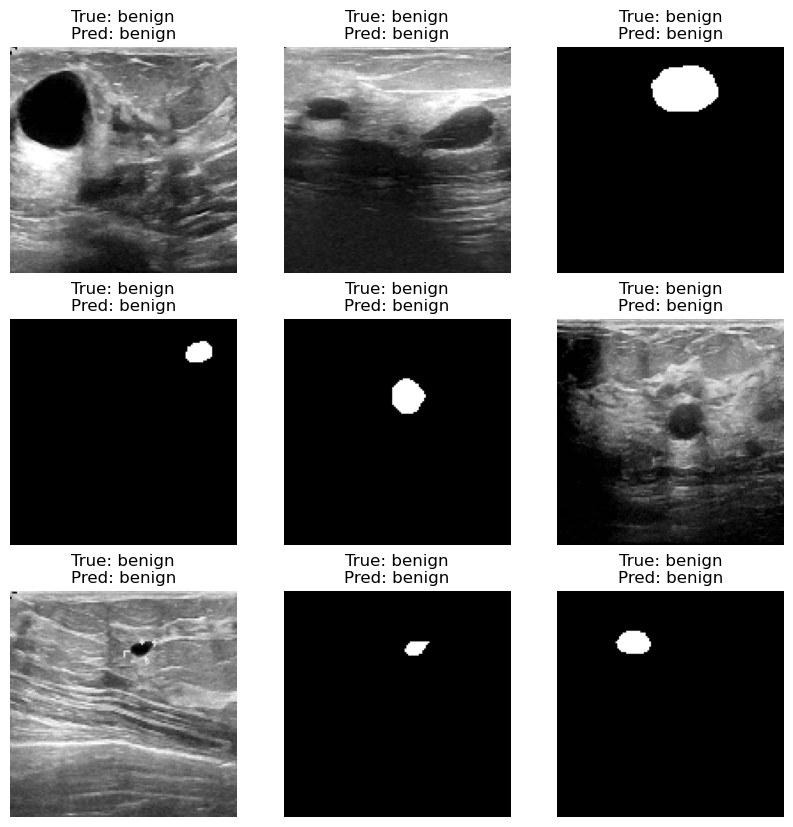

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the dataset path and labels
base_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
new_base_dir = 'breast_ultrasound_images/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
classes = ['benign', 'malignant', 'normal']

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Load ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('classification_model_resnet50.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.
Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.6603
Epoch 1: val_loss improved from inf to 0.52019, saving model to classification_model.keras
40/40 [==============================] - 16s 303ms/step - loss: 0.7465 - accuracy: 0.6603 - val_loss: 0.5202 - val_accuracy: 0.8208 - lr: 1.0000e-04
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.7508
Epoch 2: val_loss improved from 0.52019 to 0.38104, saving model to classification_model.keras
40/40 [==============================] - 12s 288ms/step - loss: 0.5526 - accuracy: 0.7508 - val_loss: 0.3810 - val_accuracy: 0.8616 - lr: 1.0000e-04
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.7992
Epoch 3: val_loss improved from 0.38104 to 0.33600, saving model to classification_model.keras
40/40 [==============================] - 12s 289ms/st

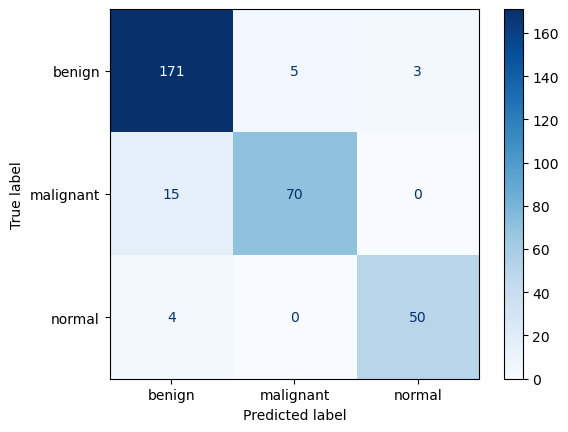

1/1 [==============================] - 1s 527ms/step


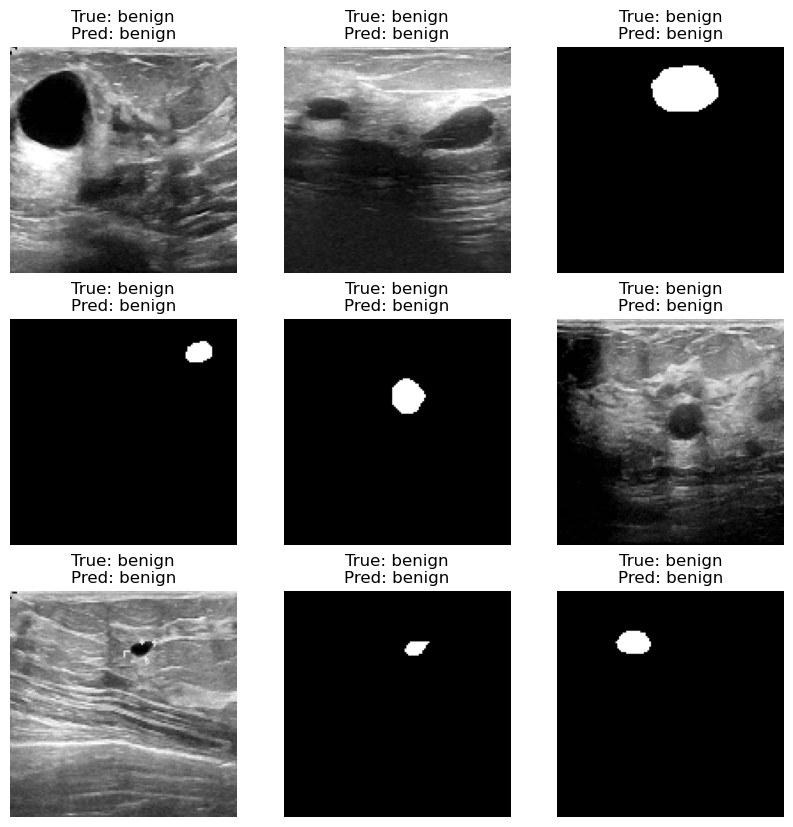

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the dataset path and labels
base_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
new_base_dir = 'breast_ultrasound_images/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
classes = ['benign', 'malignant', 'normal']

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.
Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.8458 - accuracy: 0.5770
Epoch 1: val_loss improved from inf to 0.71256, saving model to classification_model.keras
40/40 [==============================] - 17s 284ms/step - loss: 0.8458 - accuracy: 0.5770 - val_loss: 0.7126 - val_accuracy: 0.6730 - lr: 1.0000e-04
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.6889
Epoch 2: val_loss improved from 0.71256 to 0.48845, saving model to classification_model.keras
40/40 [==============================] - 12s 294ms/step - loss: 0.6396 - accuracy: 0.6889 - val_loss: 0.4884 - val_accuracy: 0.7579 - lr: 1.0000e-04
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.5990 - accuracy: 0.6968
Epoch 3: val_loss improved from 0.48845 to 0.40933, saving model to classification_model.keras
40/40 [==============================] - 12s 293ms/st

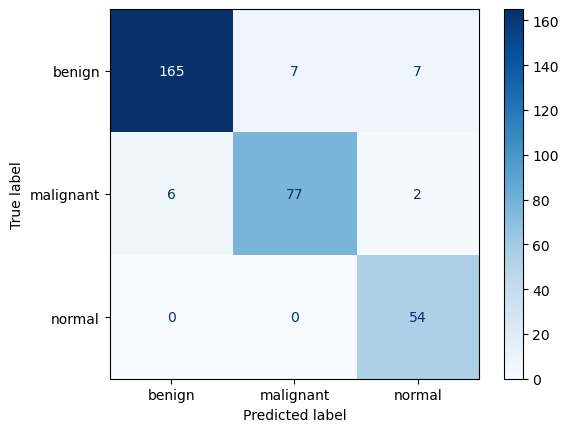

1/1 [==============================] - 1s 543ms/step


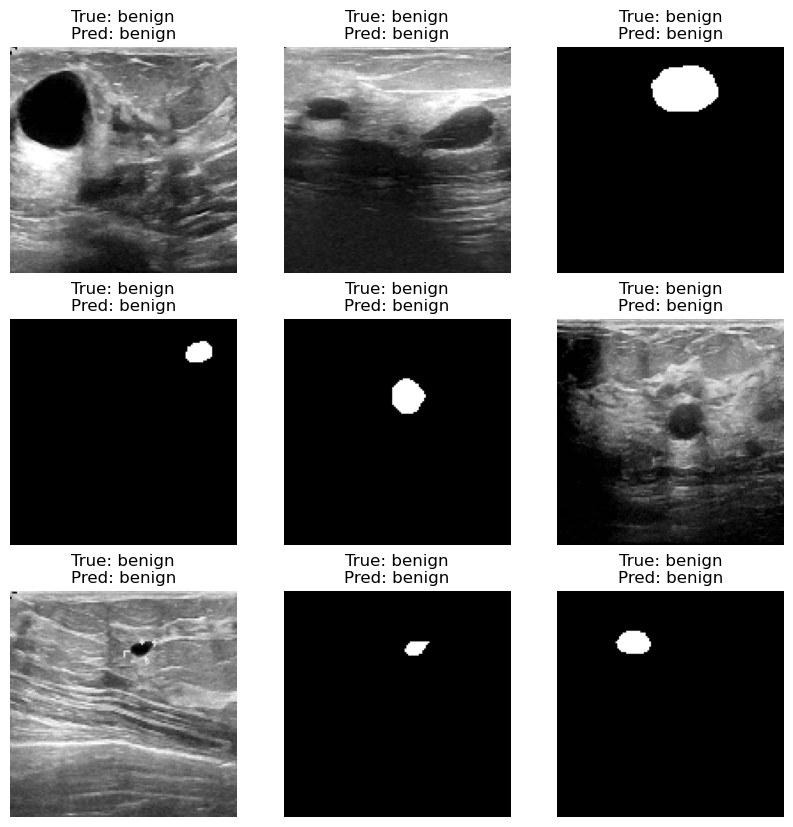

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the dataset path and labels
base_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
new_base_dir = 'breast_ultrasound_images/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
classes = ['benign', 'malignant', 'normal']

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=15, verbose=1, restore_best_weights=True),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.
Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.7717 - accuracy: 0.6198
Epoch 1: val_loss improved from inf to 0.41061, saving model to classification_model.keras
40/40 [==============================] - 15s 299ms/step - loss: 0.7717 - accuracy: 0.6198 - val_loss: 0.4106 - val_accuracy: 0.8302 - lr: 1.0000e-04
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.5500 - accuracy: 0.7563
Epoch 2: val_loss improved from 0.41061 to 0.36754, saving model to classification_model.keras
40/40 [==============================] - 11s 282ms/step - loss: 0.5500 - accuracy: 0.7563 - val_loss: 0.3675 - val_accuracy: 0.8491 - lr: 1.0000e-04
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.7556
Epoch 3: val_loss did not improve from 0.36754
40/40 [==============================] - 11s 268ms/step - loss: 0.5319 - accuracy: 0.7556 - val_loss:

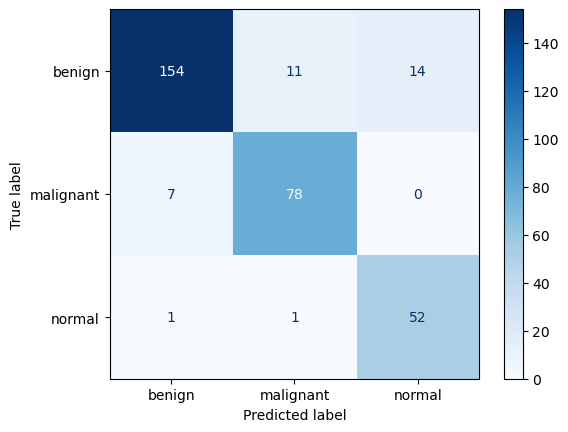

1/1 [==============================] - 1s 524ms/step


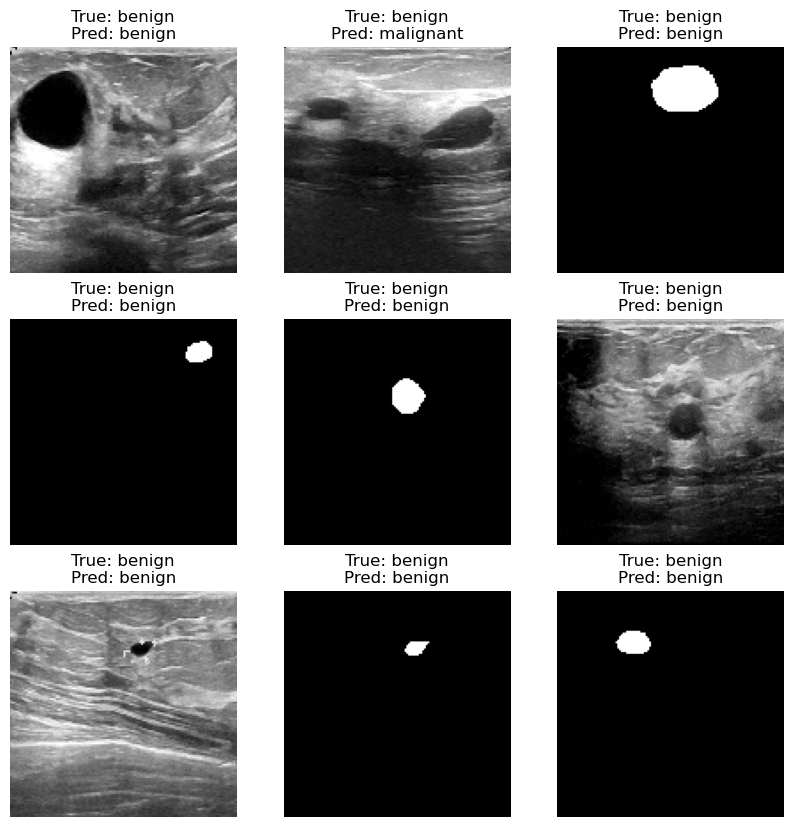

In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the dataset path and labels
base_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
new_base_dir = 'breast_ultrasound_images/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
classes = ['benign', 'malignant', 'normal']

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.3,  # Increased width shift range
    height_shift_range=0.3,  # Increased height shift range
    shear_range=0.3,  # Increased shear range
    zoom_range=0.3,  # Increased zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Fine-tune more layers of the VGG16 model
for layer in base_model.layers[:-4]:  # Fine-tune last 4 layers
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=20, verbose=1, restore_best_weights=True),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.
Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.8337 - accuracy: 0.5865
Epoch 1: val_loss improved from inf to 0.35637, saving model to classification_model.keras
40/40 [==============================] - 14s 295ms/step - loss: 0.8337 - accuracy: 0.5865 - val_loss: 0.3564 - val_accuracy: 0.8585 - lr: 1.0000e-04
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.5297 - accuracy: 0.7460
Epoch 2: val_loss did not improve from 0.35637
40/40 [==============================] - 11s 265ms/step - loss: 0.5297 - accuracy: 0.7460 - val_loss: 0.4291 - val_accuracy: 0.8302 - lr: 1.0000e-04
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.7492
Epoch 3: val_loss did not improve from 0.35637
40/40 [==============================] - 11s 267ms/step - loss: 0.5328 - accuracy: 0.7492 - val_loss: 0.3637 - val_accuracy: 0.8239 - lr: 1.0000e-04


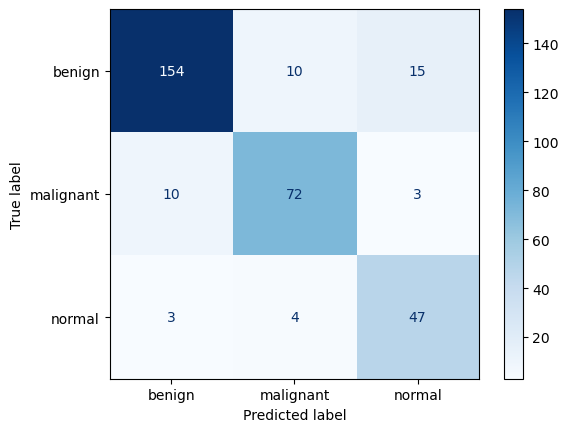

1/1 [==============================] - 1s 542ms/step


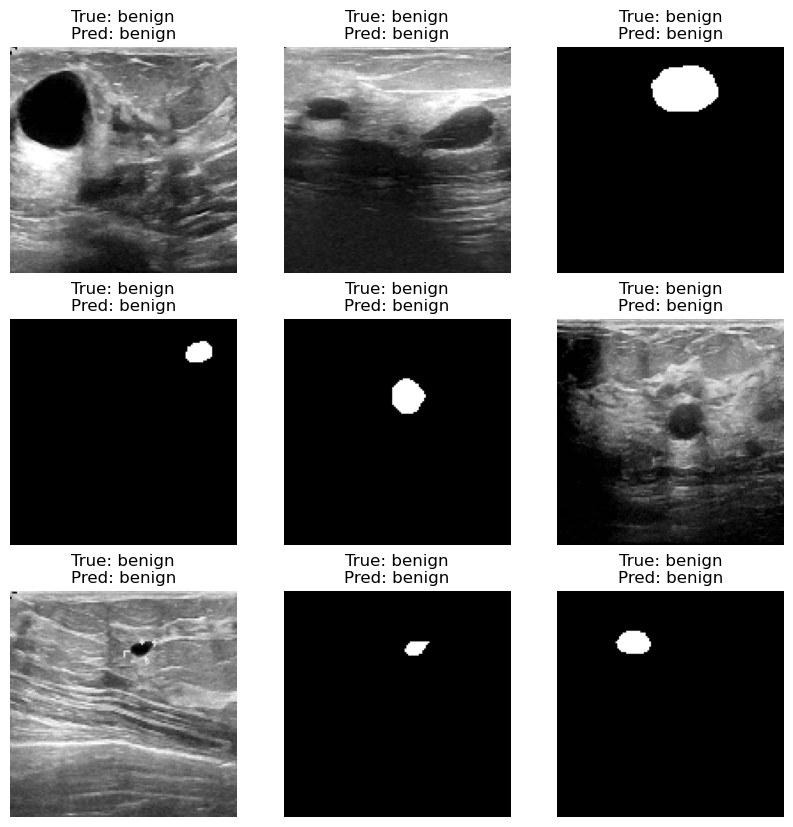

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the dataset path and labels
base_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
new_base_dir = 'breast_ultrasound_images/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
classes = ['benign', 'malignant', 'normal']

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.3,  # Increased width shift range
    height_shift_range=0.3,  # Increased height shift range
    shear_range=0.3,  # Increased shear range
    zoom_range=0.3,  # Increased zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Fine-tune more layers of the VGG16 model
for layer in base_model.layers[:-4]:  # Fine-tune last 4 layers
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=20, verbose=1, restore_best_weights=True),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.
Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.7357 - accuracy: 0.6643
Epoch 1: val_loss improved from inf to 0.42941, saving model to classification_model.keras
40/40 [==============================] - 14s 289ms/step - loss: 0.7357 - accuracy: 0.6643 - val_loss: 0.4294 - val_accuracy: 0.8396 - lr: 1.0000e-04
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.7770
Epoch 2: val_loss improved from 0.42941 to 0.39087, saving model to classification_model.keras
40/40 [==============================] - 11s 280ms/step - loss: 0.5256 - accuracy: 0.7770 - val_loss: 0.3909 - val_accuracy: 0.8522 - lr: 1.0000e-04
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.5180 - accuracy: 0.7944
Epoch 3: val_loss did not improve from 0.39087
40/40 [==============================] - 11s 264ms/step - loss: 0.5180 - accuracy: 0.7944 - val_loss:

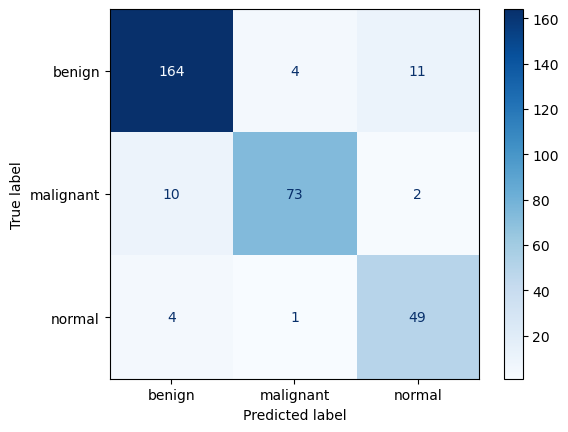

1/1 [==============================] - 1s 523ms/step


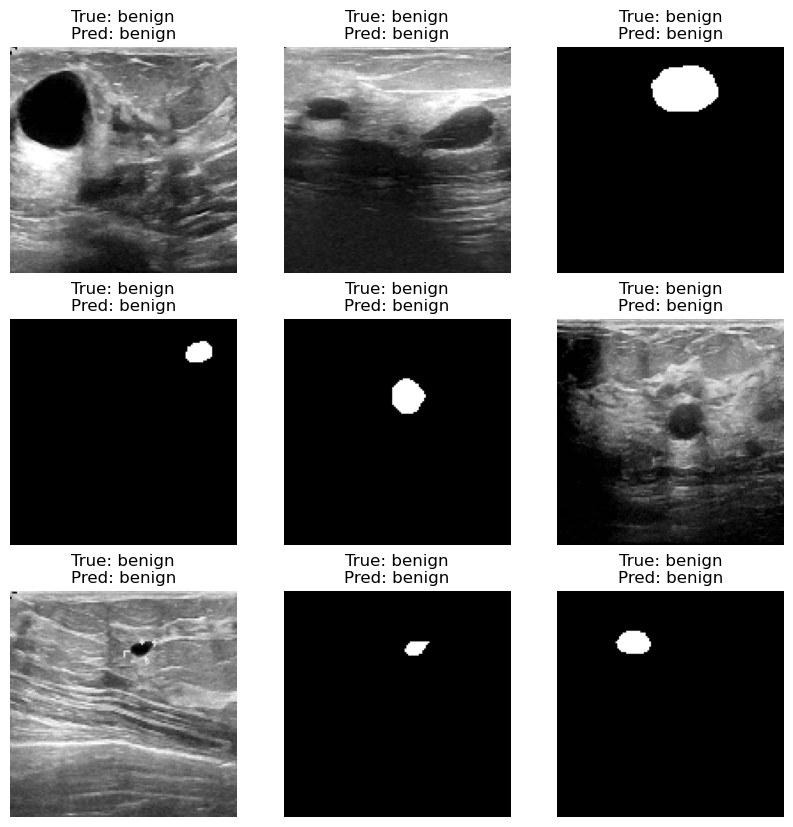

In [10]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the dataset path and labels
base_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
new_base_dir = 'breast_ultrasound_images/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
classes = ['benign', 'malignant', 'normal']

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        # Oversample minority classes in the training set
        max_samples = max([len(train_files) for train_files in train_test_split(files, test_size=split_ratio, random_state=42)[0]])
        
        train_files = train_files * (max_samples // len(train_files)) + train_files[:max_samples % len(train_files)]
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.3,  # Increased width shift range
    height_shift_range=0.3,  # Increased height shift range
    shear_range=0.3,  # Increased shear range
    zoom_range=0.3,  # Increased zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Fine-tune more layers of the VGG16 model
for layer in base_model.layers[:-4]:  # Fine-tune last 4 layers
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=20, verbose=1, restore_best_weights=True),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.
Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.6937
Epoch 1: val_loss improved from inf to 0.36855, saving model to classification_model.keras
40/40 [==============================] - 15s 297ms/step - loss: 0.6799 - accuracy: 0.6937 - val_loss: 0.3686 - val_accuracy: 0.8396 - lr: 1.0000e-04
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8024
Epoch 2: val_loss did not improve from 0.36855
40/40 [==============================] - 11s 264ms/step - loss: 0.4480 - accuracy: 0.8024 - val_loss: 0.3758 - val_accuracy: 0.8396 - lr: 1.0000e-04
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.4272 - accuracy: 0.8127
Epoch 3: val_loss improved from 0.36855 to 0.36779, saving model to classification_model.keras
40/40 [==============================] - 11s 281ms/step - loss: 0.4272 - accuracy: 0.8127 - val_loss: 0.

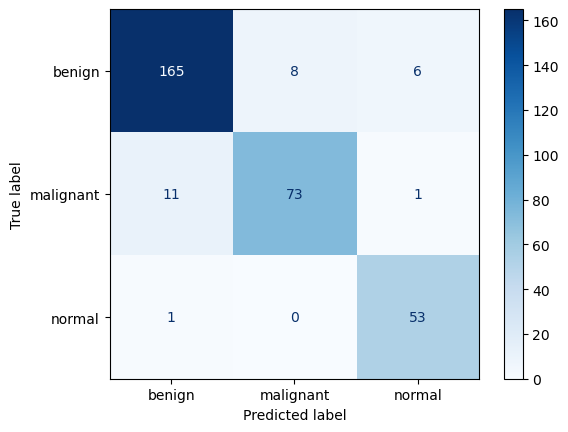

1/1 [==============================] - 1s 525ms/step


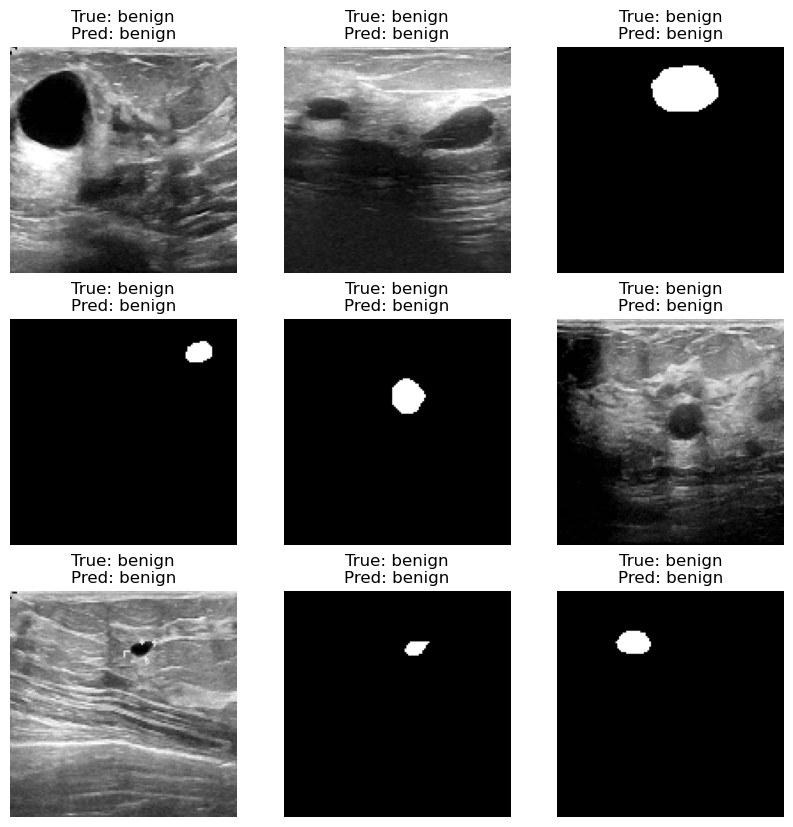

In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the dataset path and labels
base_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
new_base_dir = 'breast_ultrasound_images/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
classes = ['benign', 'malignant', 'normal']

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Fine-tune more layers of the VGG16 model
for layer in base_model.layers[:-8]:  # Fine-tune last 8 layers
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=15, verbose=1, restore_best_weights=True),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Reduced epochs to monitor overfitting
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.
Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.6794
Epoch 1: val_loss improved from inf to 0.45067, saving model to classification_model.keras
40/40 [==============================] - 16s 326ms/step - loss: 0.7330 - accuracy: 0.6794 - val_loss: 0.4507 - val_accuracy: 0.7830 - lr: 1.0000e-04
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.7683
Epoch 2: val_loss improved from 0.45067 to 0.38310, saving model to classification_model.keras
40/40 [==============================] - 11s 286ms/step - loss: 0.4928 - accuracy: 0.7683 - val_loss: 0.3831 - val_accuracy: 0.8176 - lr: 1.0000e-04
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.7937
Epoch 3: val_loss improved from 0.38310 to 0.32607, saving model to classification_model.keras
40/40 [==============================] - 11s 285ms/step 

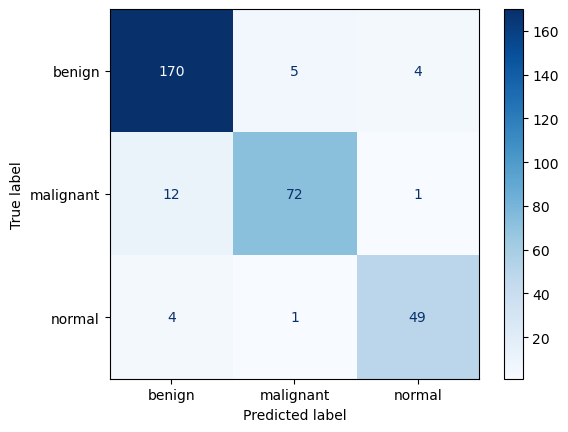

1/1 [==============================] - 1s 521ms/step


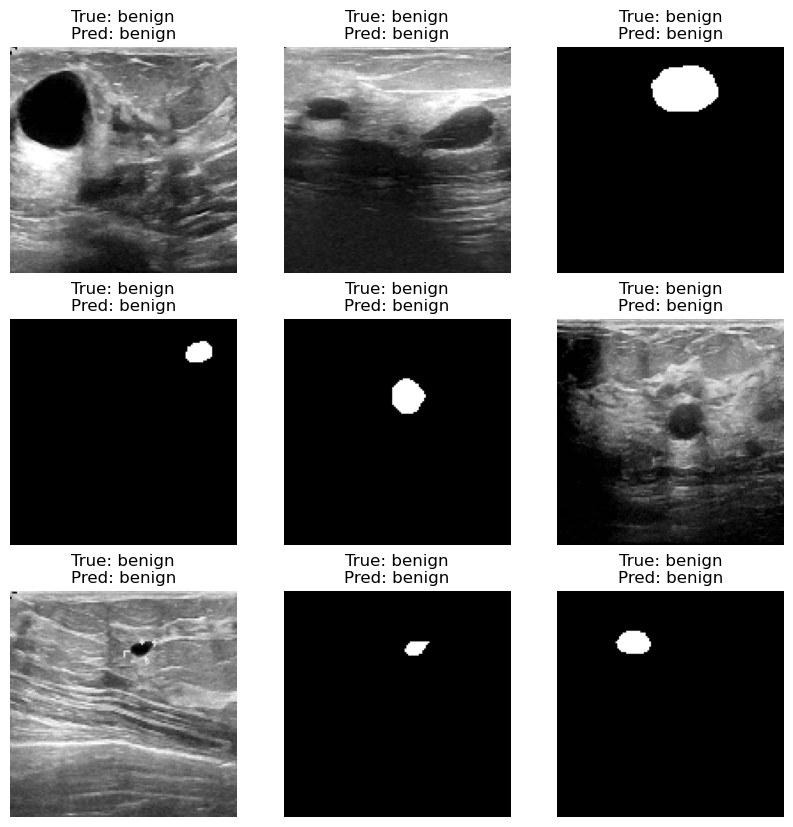

In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the dataset path and labels
base_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
new_base_dir = 'breast_ultrasound_images/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
classes = ['benign', 'malignant', 'normal']

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Fine-tune more layers of the VGG16 model
for layer in base_model.layers[:-12]:  # Fine-tune last 12 layers
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=15, verbose=1, restore_best_weights=True),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Reduced epochs to monitor overfitting
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.
Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 0.6264 - accuracy: 0.7079
Epoch 1: val_loss improved from inf to 0.34102, saving model to classification_model.keras
40/40 [==============================] - 15s 295ms/step - loss: 0.6264 - accuracy: 0.7079 - val_loss: 0.3410 - val_accuracy: 0.8616 - lr: 1.0000e-04
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.7627
Epoch 2: val_loss did not improve from 0.34102
40/40 [==============================] - 11s 264ms/step - loss: 0.5025 - accuracy: 0.7627 - val_loss: 0.4675 - val_accuracy: 0.7830 - lr: 1.0000e-04
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.7921
Epoch 3: val_loss did not improve from 0.34102
40/40 [==============================] - 11s 265ms/step - loss: 0.4443 - accuracy: 0.7921 - val_loss: 0.4900 - val_accuracy: 0.8145 - lr: 1.0000e-04
Epo

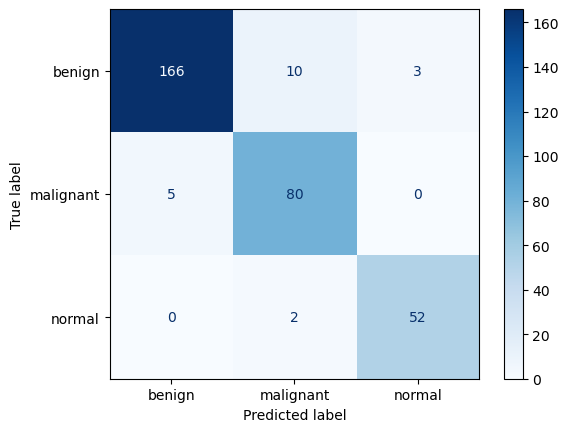

1/1 [==============================] - 1s 522ms/step


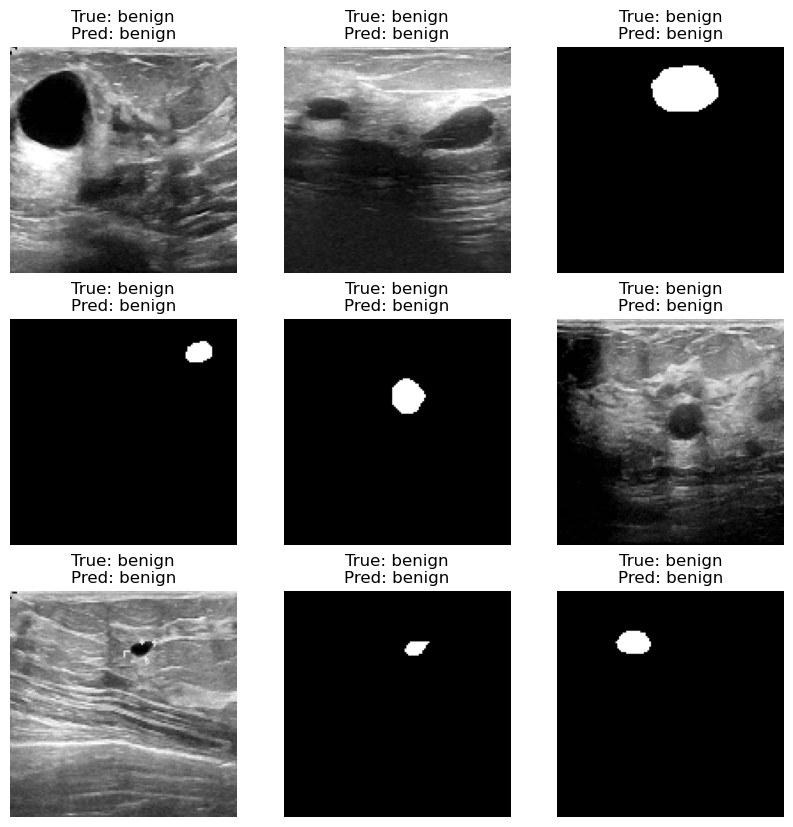

In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the dataset path and labels
base_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
new_base_dir = 'breast_ultrasound_images/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
classes = ['benign', 'malignant', 'normal']

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Fine-tune more layers of the VGG16 model
for layer in base_model.layers[:-8]:  # Fine-tune last 8 layers
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=20, verbose=1, restore_best_weights=True),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


In [14]:
# Save the trained model
model.save('breast_ultrasound_classification_model.h5')


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 318 images belonging to 3 classes.
10/10 [==============================] - 2s 127ms/step
Classification Report:

              precision    recall  f1-score   support

      benign       0.97      0.93      0.95       179
   malignant       0.87      0.94      0.90        85
      normal       0.95      0.96      0.95        54

    accuracy                           0.94       318
   macro avg       0.93      0.94      0.94       318
weighted avg       0.94      0.94      0.94       318



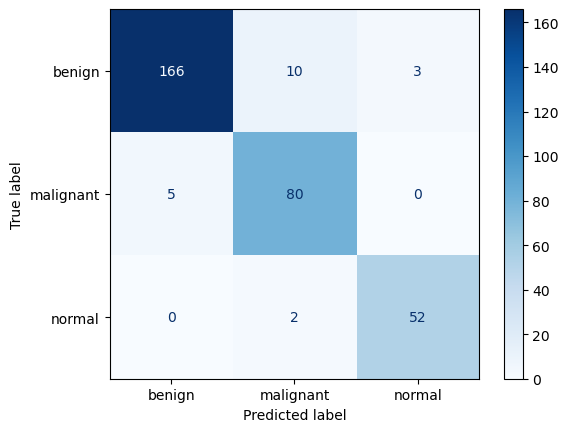

1/1 [==============================] - 1s 516ms/step


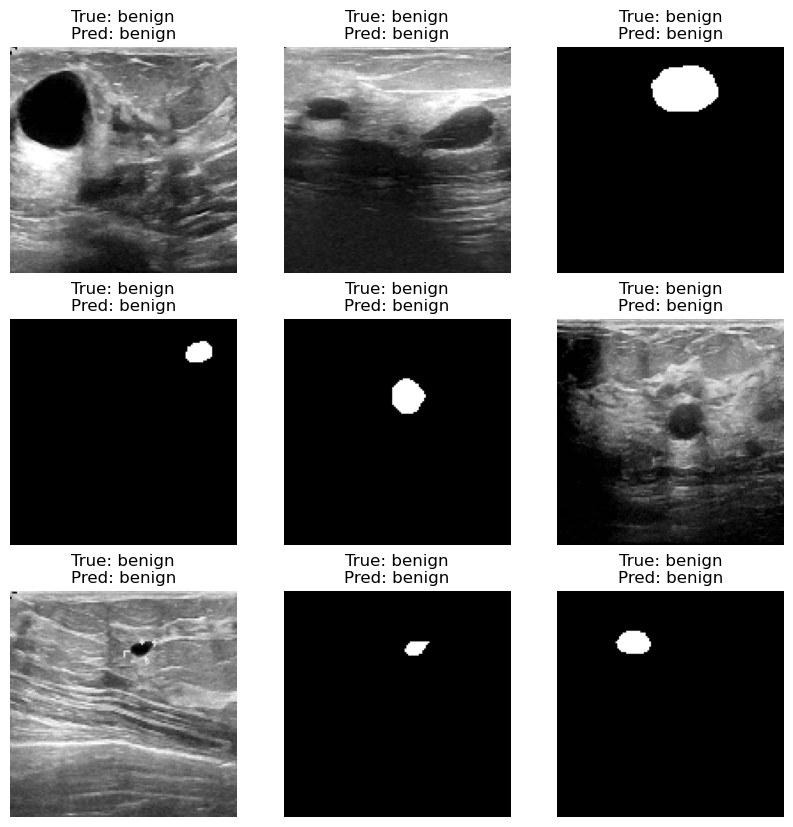

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = load_model('breast_ultrasound_classification_model.h5')

# Define the class labels
class_labels = ['benign', 'malignant', 'normal']

# Directory containing validation images (use your validation directory)
val_dir = 'breast_ultrasound_images/breast_ultrasound_split/val'

# Data generator for validation images
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the validation dataset
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Function to plot images with true and predicted labels
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Reset the validation generator and get a batch of validation images
val_generator.reset()
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 318 images belonging to 3 classes.
10/10 [==============================] - 2s 124ms/step
Classification Report:

              precision    recall  f1-score   support

      benign       0.97      0.93      0.95       179
   malignant       0.87      0.94      0.90        85
      normal       0.95      0.96      0.95        54

    accuracy                           0.94       318
   macro avg       0.93      0.94      0.94       318
weighted avg       0.94      0.94      0.94       318



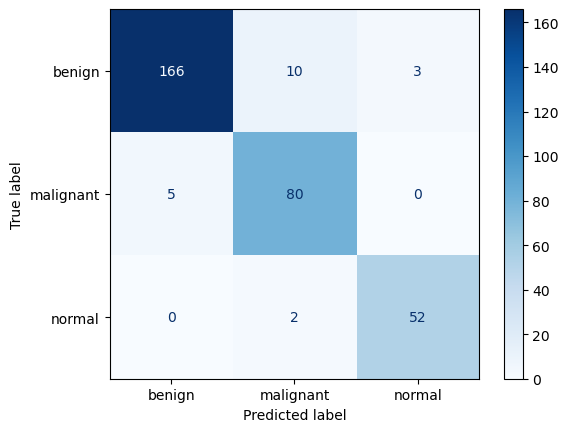

1/1 [==============================] - 1s 551ms/step


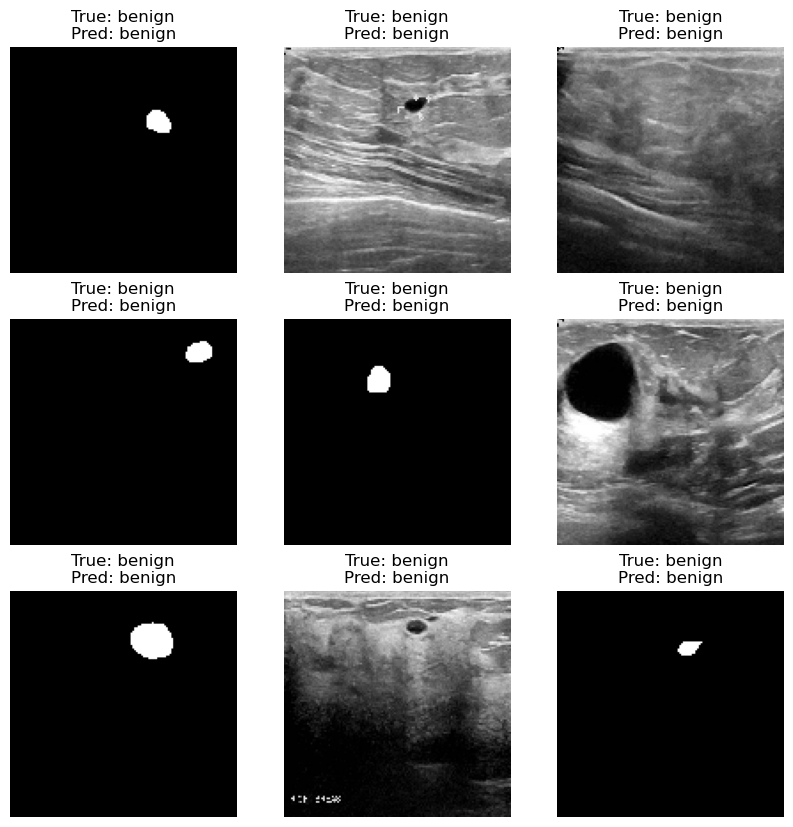

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random

# Load the trained model
model = load_model('breast_ultrasound_classification_model.h5')

# Define the class labels
class_labels = ['benign', 'malignant', 'normal']

# Directory containing validation images (use your validation directory)
val_dir = 'breast_ultrasound_images/breast_ultrasound_split/val'

# Data generator for validation images
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the validation dataset
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Function to plot a random selection of images with true and predicted labels
def plot_random_images(images, labels, preds, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    indices = random.sample(range(len(images)), num_images)
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[labels[idx]]}\nPred: {class_names[preds[idx]]}")
        plt.axis('off')
    plt.show()

# Reset the validation generator to get a batch of validation images
val_generator.reset()
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot a random selection of images with true and predicted labels
plot_random_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


Found 318 images belonging to 3 classes.
10/10 [==============================] - 2s 124ms/step
Classification Report:

              precision    recall  f1-score   support

      benign       0.97      0.93      0.95       179
   malignant       0.87      0.94      0.90        85
      normal       0.95      0.96      0.95        54

    accuracy                           0.94       318
   macro avg       0.93      0.94      0.94       318
weighted avg       0.94      0.94      0.94       318



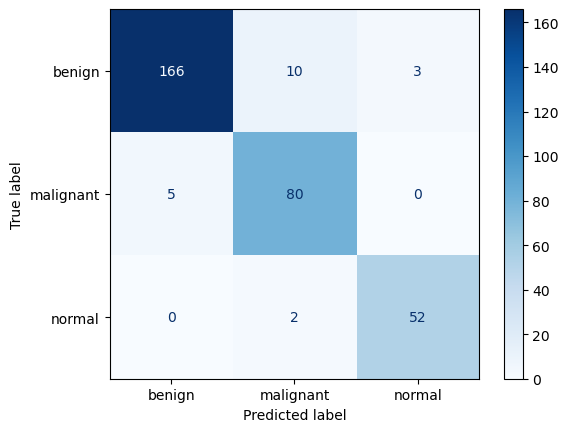

1/1 [==============================] - 1s 532ms/step


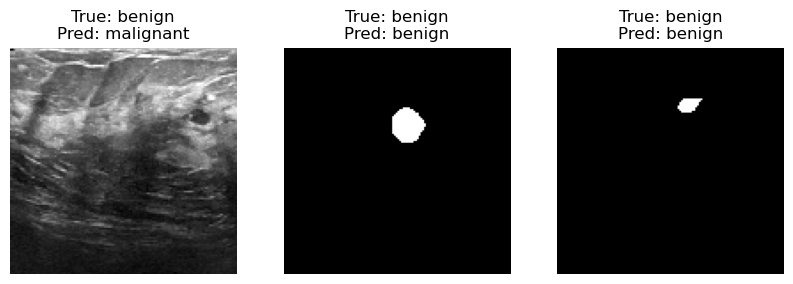

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random

# Load the trained model
model = load_model('breast_ultrasound_classification_model.h5')

# Define the class labels
class_labels = ['benign', 'malignant', 'normal']

# Directory containing validation images (use your validation directory)
val_dir = 'breast_ultrasound_images/breast_ultrasound_split/val'

# Data generator for validation images
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the validation dataset
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Function to plot a random selection of images from different classes
def plot_images_from_different_classes(images, labels, preds, class_names, num_images_per_class=3):
    plt.figure(figsize=(10, 10))
    class_indices = {class_name: [] for class_name in class_names}
    
    for idx, label in enumerate(labels):
        class_indices[class_names[label]].append(idx)
    
    selected_indices = []
    for class_name in class_names:
        if len(class_indices[class_name]) >= num_images_per_class:
            selected_indices.extend(random.sample(class_indices[class_name], num_images_per_class))
        else:
            selected_indices.extend(class_indices[class_name])
    
    for i, idx in enumerate(selected_indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[labels[idx]]}\nPred: {class_names[preds[idx]]}")
        plt.axis('off')
    plt.show()

# Reset the validation generator and get a batch of validation images
val_generator.reset()
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot a random selection of images with true and predicted labels from different classes
plot_images_from_different_classes(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


1/1 [==============================] - 1s 536ms/step


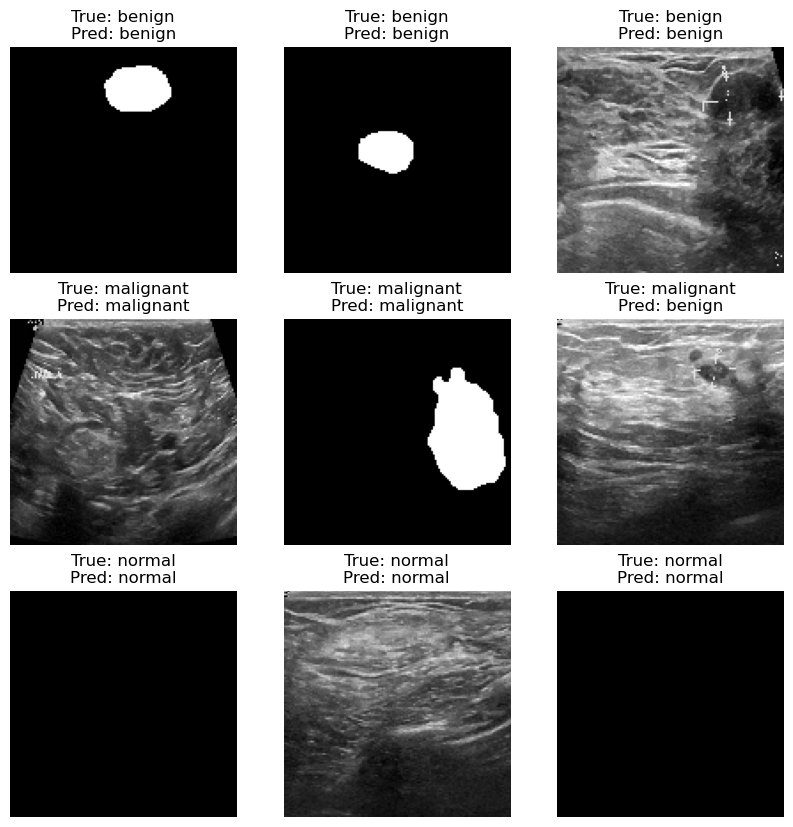

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random

# Load the trained model
model = load_model('breast_ultrasound_classification_model.h5')

# Define the class labels
class_labels = ['benign', 'malignant', 'normal']

# Directory containing original dataset images
dataset_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'

# Data generator for image preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = datagen.standardize(image)
    return image

# Function to get a random selection of images from each class
def get_random_images_from_classes(dataset_dir, class_labels, num_images_per_class=3):
    images = []
    true_labels = []
    original_images = []
    for class_label in class_labels:
        class_dir = os.path.join(dataset_dir, class_label)
        class_images = os.listdir(class_dir)
        selected_images = random.sample(class_images, min(num_images_per_class, len(class_images)))
        for img_name in selected_images:
            img_path = os.path.join(class_dir, img_name)
            images.append(load_and_preprocess_image(img_path))
            original_images.append(load_img(img_path, target_size=(128, 128)))
            true_labels.append(class_labels.index(class_label))
    return images, true_labels, original_images

# Get random images from each class
images, true_labels, original_images = get_random_images_from_classes(dataset_dir, class_labels, num_images_per_class=3)

# Flatten the list of images
images = np.vstack(images)

# Make predictions
preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)

# Function to plot images with true and predicted labels
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    num_images = len(images)
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Plot the images with true and predicted labels
plot_images(original_images, true_labels, pred_classes, class_labels)
